In [1]:
%matplotlib inline

import numpy as np
import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
from __future__ import division

import pandas as pd

In [4]:
# read in VRT stack of all standardized results
stable = '0515'
VRT = '../paper_data/int_products/2016_stack_{stable}_diff_G_standardized.vrt'.format(stable=stable)

with rasterio.open(VRT) as image:
    obs_ds = image.read()
print(obs_ds.shape)

(16, 9729, 12851)


In [5]:
# calculate number of good values per pixel
no_data = -9999
nobs = np.sum(obs_ds != no_data, axis=0)
print(nobs.shape)

(9729, 12851)


In [6]:
# write number of observations to raster
in_ds = gdal.Open(VRT, gdal.GA_ReadOnly)
output_fn = '../paper_data/final_products/2016_{stable}_nobs.tif'.format(stable=stable)

out_driver = gdal.GetDriverByName("GTiff")
out_ds = out_driver.Create(output_fn, 
                           nobs.shape[1],  # x size
                           nobs.shape[0],  # y size
                           1,  # number of bands
                           gdal.GDT_Int32)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())
out_ds.GetRasterBand(1).WriteArray(nobs)
#out_ds.GetRasterBand(1).SetNoDataValue(-9999)
#out_ds.GetRasterBand(1).SetColorTable(ct)
out_ds.GetRasterBand(1).SetDescription('number of observation per pixel')
out_ds = None

In [7]:
# Create NLCD forest mask
NLCD = '../paper_data/final_products/NLCD_clip.tif'

with rasterio.open(NLCD) as image:
    NLCD = image.read(1)
print(NLCD.shape)

NLCD_forest = np.zeros(NLCD.shape, dtype=int)
NLCD_forest[NLCD == 41] = 1
NLCD_forest[NLCD == 42] = 1
NLCD_forest[NLCD == 43] = 1
NLCD_forest[nobs == 0]  = -9999
NLCD_forest.shape

# write mean to raster
output_fn = '../paper_data/final_products/NLCD_forest_mask.tif'

out_driver = gdal.GetDriverByName("GTiff")
out_ds = out_driver.Create(output_fn, 
                           nobs.shape[1],  # x size
                           nobs.shape[0],  # y size
                           1,  # number of bands
                           gdal.GDT_Int32)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())
out_ds.GetRasterBand(1).WriteArray(NLCD_forest)
out_ds.GetRasterBand(1).SetNoDataValue(-9999) 
#out_ds.GetRasterBand(1).SetColorTable(ct)
out_ds.GetRasterBand(1).SetDescription('Forest/Non-forest mask from 2011 NLCD')
out_ds = None

(9729, 12851)


In [8]:
# change no data value to nan
obs_ds[obs_ds == no_data] = np.nan

In [9]:
# sum across bands, ignoring nan
sum_all = np.nansum(obs_ds, axis=0)

In [10]:
# calculate mean
mean_all = sum_all / nobs

/projectnb/landsat/users/valpasq/conda/envs/moths/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


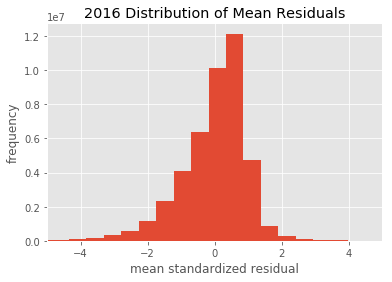

In [11]:
# Create histogram of mean residuals
mean_all_hist = mean_all.reshape(mean_all.size)
plt.hist(mean_all_hist[~np.isnan(mean_all_hist)], 1000)
plt.title('2016 Distribution of Mean Residuals')
plt.xlim(-5,5)
plt.xlabel('mean standardized residual')
plt.ylabel('frequency')
plt.savefig('../paper_data/final_products/2016_{stable}_histogram.eps'.format(stable=stable))
plt.show()

In [12]:
# mask pixels where nobs=0
mean_all[nobs == 0] = -9999

In [13]:
# write mean to raster
output_fn = '../paper_data/final_products/2016_{stable}_meanresiduals.tif'.format(stable=stable)

out_driver = gdal.GetDriverByName("GTiff")
out_ds = out_driver.Create(output_fn, 
                           nobs.shape[1],  # x size
                           nobs.shape[0],  # y size
                           1,  # number of bands
                           gdal.GDT_Float64)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())
out_ds.GetRasterBand(1).WriteArray(mean_all)
out_ds.GetRasterBand(1).SetNoDataValue(-9999)
#out_ds.GetRasterBand(1).SetColorTable(ct)
out_ds.GetRasterBand(1).SetDescription('mean standardized residual')
out_ds = None

In [16]:
# read in NLCD for masking
with rasterio.open('../paper_data/final_products/NLCD_forest_mask.tif') as image:
    NLCD = image.read(1)
print(NLCD.shape)

(9729, 12851)


In [17]:
# mask non-forest
mean_all[NLCD == 0] = -9999

In [18]:
in_ds = gdal.Open(VRT, gdal.GA_ReadOnly)
# write mean to raster
output_fn = '../paper_data/final_products/2016_{stable}_meanresiduals_forestmask.tif'.format(stable=stable)

out_driver = gdal.GetDriverByName("GTiff")
out_ds = out_driver.Create(output_fn, 
                           nobs.shape[1],  # x size
                           nobs.shape[0],  # y size
                           1,  # number of bands
                           gdal.GDT_Float64)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())
out_ds.GetRasterBand(1).WriteArray(mean_all)
out_ds.GetRasterBand(1).SetNoDataValue(-9999)
#out_ds.GetRasterBand(1).SetColorTable(ct)
out_ds.GetRasterBand(1).SetDescription('mean standardized residual')
out_ds = None